In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from ae import AutoEncoder
import torch
from torchvision.transforms import transforms
%reload_ext autoreload
%autoreload 2


In [3]:
def load_image_as_np(image_path):
    return np.asarray(Image.open(image_path).convert('RGB'), dtype=np.uint8)

def store_image_from_np(image_path,data,format='RGB'):
    img = Image.fromarray(data, format)
    img.save(image_path)
    return img

In [4]:
def segment_image(image,tile_size,pad_type='reflect'):
    img_height,img_width = image.shape[:2]

    # Pads the image so it can be chunked down to a grid even if the size of the image is not
    # divisible by the chunk size
    v_pad = (0,tile_size - (img_height % tile_size)) if img_height % tile_size != 0 else (0,0)
    h_pad = (0,tile_size - (img_width % tile_size)) if img_width % tile_size != 0 else (0,0)
        
    image = np.pad(image, (v_pad,h_pad,(0,0)), pad_type)

    img_height , img_width, channels = image.shape

    tiled_array =  image.reshape(img_height // tile_size,
                                 tile_size,
                                 img_width // tile_size,
                                 tile_size,
                                 channels)

    tiled_array = tiled_array.swapaxes(1,2)

    return np.concatenate(tiled_array,axis=0)


In [5]:
def rebuild_image(tile_array,image_size,tile_size):
    img_height, img_width, channels = image_size
    
    tile_rows = int(np.ceil(img_height/tile_size))
    tile_cols = int(np.ceil(img_width/tile_size))

    tile_array = tile_array.reshape(tile_rows,
                                    tile_cols,
                                    tile_size,
                                    tile_size,
                                    channels)
    
    tile_array = np.concatenate(tile_array,axis=1)
    tile_array = np.concatenate(tile_array,axis=1)

    return tile_array[:img_height,:img_width]

In [6]:
def get_model(model_path):
    model = AutoEncoder.load_autoencoder(model_path)
    return send_to_device(model)


def send_to_device(pytorch_object):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pytorch_object = pytorch_object.to(device)
    return pytorch_object


def apply_compress_function(tile_tensor, model_path):
    model = get_model(model_path)
    return model.encode(send_to_device(tile_tensor))

def apply_decompression_function(encoded_tile_tensor,model_path) :
    model = get_model(model_path)
    return model.decode(encoded_tile_tensor)

In [7]:
def make_tensor(tile_list_array:np.array)-> torch.tensor:    
    tile_list_array = tile_list_array.swapaxes(2,3)
    tile_list_array = tile_list_array.swapaxes(1,2)
    
    tile_list_tensor = torch.from_numpy(tile_list_array.astype('float32')).reshape(-1,3*8*8)
    #print("Make Tensor tile_list_array.shape=",tile_list_tensor.size())
    return tile_list_tensor /255


def retrieve_array(decoded_tile_tensor):
    res = decoded_tile_tensor.detach().cpu().reshape(-1,3,8,8)
    res = (res.numpy() * 255).astype('uint8')
    res = res.swapaxes(1,2)    
    res = res.swapaxes(2,3)
    return res

Test Image           (8, 8, 3)
Tile List            (1, 8, 8, 3)
Tile_tensor torch    torch.Size([1, 192])
Comp Image Tensor    tensor([[ 2.8801, -2.6291,  2.2790,  2.2777,  1.9334,  2.0447,  2.9021,  2.5200]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Rebuilt Image Tensor torch.Size([1, 192])
Rebuilt image array  (1, 8, 8, 3)
Rebuilt Image        (8, 8, 3)
Reconstructed


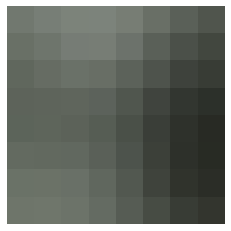

Original


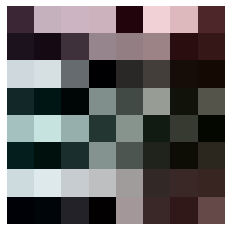

In [8]:
wd_path = os.path.abspath(os.getcwd())
models_path = os.path.join(wd_path, "models")
model_used_path = os.path.join(models_path, "ae_1.pt")
image_path = os.path.join(wd_path,"images","val_0_0.jpeg")
image_path_out = os.path.join(wd_path,"images","val_0_0_out.jpeg")
tile_size= 8

test_image                  = load_image_as_np(image_path)
print("Test Image          ",test_image.shape)

tile_list                   = segment_image(test_image,tile_size=8,pad_type='reflect')
print("Tile List           ",tile_list.shape)

tile_tensor                 = make_tensor(tile_list)
print("Tile_tensor torch   ",tile_tensor.size())

compressed_image_tensor     = apply_compress_function(tile_tensor,model_used_path)
print("Comp Image Tensor   ",compressed_image_tensor)

#-------------------- DECOMPRESSION --------------
decompressed_image_tensor   = apply_decompression_function(compressed_image_tensor,model_used_path)
print("Rebuilt Image Tensor",decompressed_image_tensor.size())

decompresssed_image         = retrieve_array(decompressed_image_tensor)
print("Rebuilt image array ",decompresssed_image.shape)

end_image                   = rebuild_image(decompresssed_image,test_image.shape,tile_size)
print("Rebuilt Image       ",end_image.shape)

store_image_from_np(image_path_out, end_image)
t = transforms.ToTensor()
print("="*40)

print("Reconstructed")

plt.imshow(end_image)
plt.axis('off')
plt.show()
print("="*40)
print("Original")

plt.imshow(test_image)

plt.axis('off')
plt.show()

----------Segment Image----------
(113, 8, 150, 8, 3)
(113, 150, 8, 8, 3)
(16950, 8, 8, 3)
---------------------------------
Make Tensor tile_list_array.shape= torch.Size([16950, 8, 8, 3])
(900, 1200, 3)
Reconstructed
[180 110  24]


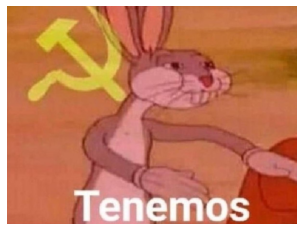

Original
[180 110  24]


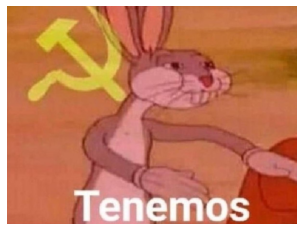

In [80]:
wd_path = os.path.abspath(os.getcwd())
models_path = os.path.join(wd_path, "models")
model_used_path = os.path.join(models_path, "ae_0.pt")
image_path = os.path.join(wd_path,"images","tenemos.png")
image_path_out = os.path.join(wd_path,"images","tenemos_out.png")
tile_size= 8

test_image                  = load_image_as_np(image_path)
tile_list                   = segment_image(test_image,tile_size=8,pad_type='reflect')
tile_list_tensor            = make_tensor(tile_list)

decompresssed_image         = retrieve_array(tile_list_tensor)
end_image                   = rebuild_image(tile_list,test_image.shape,tile_size)
print(end_image.shape)
store_image_from_np(image_path_out, end_image)
t = transforms.ToTensor()

#print(t(test_image))
print("="*40)
print("Reconstructed")
print(end_image[0,0])
#print(t(end_image))
plt.imshow(end_image)
plt.axis('off')
plt.show()
print("Original")
print(test_image[0,0])
plt.imshow(test_image)

plt.axis('off')
plt.show()

In [19]:
from autoencoder_compressor import Compressor_Decompressor

wd_path = os.path.abspath(os.getcwd())
model_path = os.path.join(wd_path, "models","ae_1.pt")
image_path = os.path.join(wd_path,"images","val_0_0.jpeg")
image_path_out = os.path.join(wd_path,"images","tenemos_out.png")
comp = Compressor_Decompressor(model_path)
c , image_size = comp.compress_image(image_path)

comp.decompress_image(c,image_path_out,image_size)
print(c)

tensor([[ 2.8801, -2.6291,  2.2790,  2.2777,  1.9334,  2.0447,  2.9021,  2.5200]])
